In [19]:
import sys
import os
PROJ_PATH = os.getcwd()
SRC_PATH = os.path.join(PROJ_PATH, 'src')
sys.path.append(PROJ_PATH)
sys.path.append(SRC_PATH)

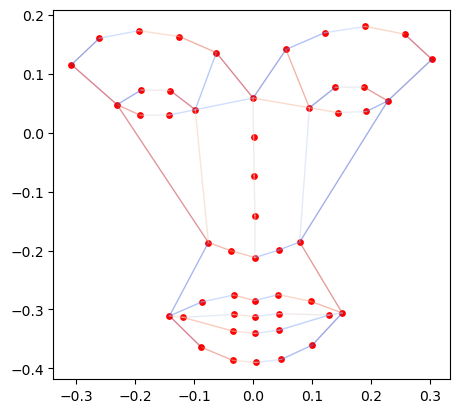

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from src.procrustes import load_meanface
from src.model import MicroExpressionModel

meanface = load_meanface()

x, edge_index, edge_attr = MicroExpressionModel.build_graph(torch.tensor(meanface))

lengths = edge_attr[:, 2]
lengths_normalized = (lengths - lengths.min()) / (lengths.max() - lengths.min() + 1e-8)
cmap = plt.get_cmap('coolwarm')

for i in range(edge_index.shape[1]//2):
    src = edge_index[0, i].item()
    tgt = edge_index[1, i].item()
    plt.plot(
        [x[src, 0], x[tgt, 0]],
        [-x[src, 1], -x[tgt, 1]],
        c=cmap(lengths_normalized[i].item()), alpha=0.5, linewidth=1
    )

plt.scatter(x[:,0], -x[:, 1], c='red', s=15)
plt.gca().set_aspect('equal')

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm
from math import ceil

def process_folder(
    folder_path,
    output_base_path,
    raw_lm_path=None,
    images_base_path=None,
    interval=200
):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    dfs = [pd.read_csv(os.path.join(folder_path, f), delimiter=';') for f in csv_files]

    n_variants = len(dfs)
    n_frames = len(dfs[0])

    rows, cols = 2, ceil(n_variants / 2)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 4.5), dpi=160, squeeze=False)
    axs = axs.flatten()

    scatters = []
    for j in range(n_variants):
        ax = axs[j]

        ax.set_xlim(-0.5, 0.5)
        ax.set_ylim(0.5, -0.5)
        ax.set_aspect('equal')
        ax.set_title(csv_files[j].replace('.csv', ''), fontsize=9)

        color = 'red' if 'original' in csv_files[j].lower() else 'blue'
        scat = ax.scatter([], [], s=10, color=color, edgecolors='none')
        scatters.append(scat)

    # === Raw landmarks ===
    raw_scat = None
    raw_ax = None
    raw_df = None
    if raw_lm_path:
        raw_df = pd.read_csv(raw_lm_path, delimiter=';')
        idx = n_variants
        if idx < len(axs):
            raw_ax = axs[idx]
            raw_ax.set_aspect('equal')
            raw_ax.set_title('raw landmarks', fontsize=9)
            raw_scat = raw_ax.scatter([], [], s=10, color='red', edgecolors='none')

    def update(frame):
        artists = []

        for j, scat in enumerate(scatters):
            xs = dfs[j].iloc[frame, 2::2].values
            ys = dfs[j].iloc[frame, 3::2].values
            scat.set_offsets(np.column_stack((xs, ys)))
            artists.append(scat)

        if raw_scat is not None:
            xs = raw_df.iloc[frame, 2::2].values
            ys = raw_df.iloc[frame, 3::2].values

            if images_base_path is not None:
                img_path = os.path.join(images_base_path, raw_df.loc[frame, 'filename'])
                if os.path.exists(img_path):
                    img = plt.imread(img_path)
                    h, w = img.shape[:2]

                    raw_ax.imshow(img, origin='upper')
                    raw_ax.set_xlim(0, w)
                    raw_ax.set_ylim(h, 0)

                    xs = ((xs + 1) / 2) * w
                    ys = ((ys + 1) / 2) * h

            else:
                raw_ax.set_xlim(-1, 1)
                raw_ax.set_ylim(1, -1)

            raw_scat.set_offsets(np.column_stack((xs, ys)))
            artists.append(raw_scat)

        return artists

    ani = FuncAnimation(fig, update, frames=n_frames, interval=interval, blit=True, repeat=True)

    output_path = os.path.join(output_base_path, f"{os.path.basename(folder_path)}.gif")
    ani.save(output_path, writer=PillowWriter(fps=1000/interval), dpi=160)

    plt.close(fig)

In [ ]:
base_path = r'data\augmented\casme3_spotting'
raw_lm_base_path = r'data\me_landmarks\casme3_spotting'
images_base_path = r'data\raw\casme3'
output_base_path = r'data\me_lm_gifs\casme3_spotting_new'
os.makedirs(output_base_path, exist_ok=True)
output_files = {os.path.basename(f)[:-4] for f in os.listdir(output_base_path)}
for subdir in tqdm(os.listdir(base_path)):
    # if subdir in output_files:
    #     continue
    full_path = os.path.join(base_path, subdir)
    raw_lm_path = os.path.join(raw_lm_base_path, subdir, 'raw_landmarks.csv')
    images_path = os.path.join(images_base_path, f'{subdir}')
    if os.path.isdir(full_path):
        process_folder(full_path, output_base_path, raw_lm_path, images_path, interval=200)
        break

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

def load_epoch(base_path:Path, epoch: int):
    prefix = f"epoch_{epoch}"
    scores = np.load(base_path / f"{prefix}_val_scores.npy")
    attn   = np.load(base_path / f"{prefix}_val_attn_weights.npy")
    lengths = np.load(base_path / f"{prefix}_val_lengths.npy")
    labels = np.load(base_path / f"{prefix}_val_labels.npy")
    preds  = np.load(base_path / f"{prefix}_val_preds.npy")
    return scores, attn, lengths, labels, preds

def plot_attention(
    base_path: Path,
    class_names: list[str],
    epoch: int,
    sample_indices=None,
    labels_path = r'data\augmented\casme3\labels.xlsx',
    num_samples: int = 10,
    mode: str = 'heatmap',
    figsize=None
):
    scores, attn, lengths, labels, preds = load_epoch(base_path, epoch)

    fragments = [Path(path).parts[-2] for path in np.load(base_path / f"val_csv_paths.npy")]
    fragments = [f.split('_') for f in fragments]
    df = pd.read_excel(labels_path, dtype=object)
    
    if sample_indices is None:
        sample_indices = range(num_samples)
    sample_indices = list(sample_indices)
    n_samples = len(sample_indices)
    
    sample_labels = []
    sample_fragments = []
    for idx in sample_indices:
        sample_fragments.append(fragments[idx])
        true = class_names[labels[idx]]
        pred = class_names[preds[idx]]
        mark = "✓" if labels[idx] == preds[idx] else "✗"
        sample_labels.append(f"{idx:3d} | {true} → {pred} {mark}")
    
    apex_indicies = []
    for subject, filename, onset in sample_fragments:
        row = df[(df['Subject'] == subject) & (df['Filename'] == filename) & (df['Onset'] == onset)].iloc[0]
        apex_indicies.append(int(row['Apex']) - int(row['Onset']))

    if mode == 'heatmap':
        global_max_len = lengths.max()
        scores_padded = np.full((n_samples, global_max_len), np.nan)
        attn_padded   = np.full((n_samples, global_max_len), np.nan)
        
        for i, idx in enumerate(sample_indices):
            l = lengths[idx]
            scores_padded[i, :l] = scores[idx, :l]
            attn_padded[i, :l] = attn[idx, :l]
        
        s_min, s_max = np.nanmin(scores_padded), np.nanmax(scores_padded)
        a_min, a_max = np.nanmin(attn_padded), np.nanmax(attn_padded)
        
        fig_height = max(3, 0.45 * n_samples)
        fig, axs = plt.subplots(n_samples, 2, figsize=figsize or (16, fig_height),gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1, 'hspace': 0.05})
        
        if n_samples == 1:
            axs = axs.reshape(1, -1)
        
        for i in range(n_samples):
            im1 = axs[i, 0].imshow(scores_padded[i:i+1], aspect='auto', cmap='Blues', vmin=s_min, vmax=s_max)
            axs[i, 0].set_yticks([]); axs[i, 0].set_xticks([])
            axs[i, 0].set_ylabel(sample_labels[i], rotation=0, ha='right', va='center', fontsize=11)

            im2 = axs[i, 1].imshow(attn_padded[i:i+1], aspect='auto', cmap='Reds', vmin=a_min, vmax=a_max)
            axs[i, 1].set_yticks([]); axs[i, 1].set_xticks([])

            apex = apex_indicies[i]
            if not np.isnan(apex) and apex < lengths[sample_indices[i]]:
                apex = int(apex)
                axs[i, 0].axvline(apex, color='black', linewidth=1, linestyle='--')
                axs[i, 1].axvline(apex, color='black', linewidth=1, linestyle='--')
        
        fig.colorbar(im1, ax=axs[:, 0], fraction=0.046, pad=0.04, label='Raw Scores')
        fig.colorbar(im2, ax=axs[:, 1], fraction=0.046, pad=0.04, label='Attention Weights')
        
        fig.suptitle(f"Epoch {epoch} — Heatmap ({n_samples} samples)", fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    
    elif mode == 'line':
        fig_height = max(3, 2.0 * n_samples)
        fig, axs = plt.subplots(n_samples, 2, figsize=figsize or (16, fig_height), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.25, 'hspace': 0.2})
        
        if n_samples == 1:
            axs = axs.reshape(1, -1)
        
        for i in range(n_samples):
            idx = sample_indices[i]
            l = lengths[idx]
            frames = np.arange(l)
            
            axs[i, 0].plot(frames, scores[idx, :l], color='tab:blue', linewidth=2)
            axs[i, 0].grid(alpha=0.3)
            axs[i, 0].set_ylabel(sample_labels[i], rotation=0, ha='right', va='center', fontsize=11)
            
            axs[i, 1].plot(frames, attn[idx, :l], color='tab:red', linewidth=2.5)
            axs[i, 1].grid(alpha=0.3)

            apex = apex_indicies[i]
            if not np.isnan(apex) and apex < l:
                apex = int(apex)
                axs[i, 0].axvline(apex, color='black', linewidth=2, linestyle='-')
                axs[i, 1].axvline(apex, color='black', linewidth=2, linestyle='-')
        
        fig.text(0.5, 0.98, f"Epoch {epoch} — Line plots ({n_samples} samples)", fontsize=16, ha='center', va='top')        
        plt.subplots_adjust(top=0.96, bottom=0.06, left=0.12, right=0.95)
        plt.show()

In [ ]:
base_path = Path(r"mlruns\746171381191466352\94c958f1ffed40d9a766c1fefe562c3e\artifacts")
class_names = ['negative', 'positive', 'surprise']
epoch = 90 
plot_attention(base_path, class_names, epoch, range(30, 50), mode='line')